# A modified CenterNet architecture for oriented bounding box detection

See the CenterNet official repo : https://github.com/xingyizhou/CenterNet

The main goal of this repo is to demonstrate how we can adapt the CenterNet ideas to multiple cars from a Bird Eye View as oriented bounding boxes. We train our network to predict a heatmap of the <b>box center</b> that is refined with an <b>offset map</b>. Then <b>bounding boxes dimensions</b> are regressed to get length and width of the vehicle. Orientation angle is also inferred with 2 heatmaps, <b>one for cosine and for sine</b>. In terms of architecture, another difference with CenterNet is that we are not using any upsampling layers, since detection of small objects doesnt require a global information of the original image.

# Summary
- import and display your dataset
- define utility functions to draw heatmaps and how we can recover oriented bounding boxes from main heatmap, offset heatmaps, width and height heatmaps, and sine/cosine heatmaps
- make a Pytorch dataset for training and validation
- define the model with a Resnet-18 backbone
- define our loss
- train the network
- display a few predictions on the validation dataset

# Imports

In [1]:
import cv2
import numpy as np
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchinfo import summary
import torch.optim as optim

assert torch.cuda.is_available()

# Not always necessary depending on your hardware/GPU
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"

In [2]:
# Here we dont assume that our images are 512x512 we prefer to use HD images (more common)
input_width = 1280
input_height = 720

# Model scale is 16, meaning that in the model prediction, we have heatmaps of dimensions 80 x 45
MODEL_SCALE = 16

# Batch size for training --> if your hardware supports it, try to increase this value
batch_size = 2

# Load dataset

Image image_0038.png
Image shape = (720, 1280, 3)
           name  img_width  img_height       x      y      w      l     angle  \
193  image_0038        720        1280   597.0  183.0  69.52  30.51 -1.586576   
194  image_0038        720        1280   372.0  333.0  69.52  30.51 -0.152053   
195  image_0038        720        1280   263.0  313.0  56.02  25.64 -0.158888   
196  image_0038        720        1280   372.0  494.0  65.86  28.93 -0.738525   
197  image_0038        720        1280   798.0  415.0  76.56  33.89 -0.395923   
198  image_0038        720        1280   905.0  402.0  73.05  27.54  2.870465   
199  image_0038        720        1280   925.0  352.0  65.00  28.21  2.870465   
200  image_0038        720        1280  1050.0  372.0  72.01  28.55  2.870465   

         h  
193  30.51  
194  30.51  
195  25.64  
196  28.93  
197  33.89  
198  27.54  
199  28.21  
200  28.55  


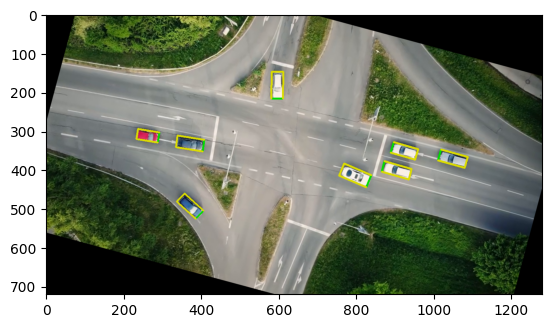

In [3]:
dataset_folder = 'images_augmented/'
labels_file = "train.csv"

# Pick up a random image
IMAGE = random.choice(os.listdir(dataset_folder))

print(f"Image {IMAGE}")

img = cv2.imread(os.path.join(dataset_folder, IMAGE))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


# Load labels
train_df = pd.read_csv(labels_file)
train_df['x'] = train_df['x'].astype(float)
train_df['y'] = train_df['y'].astype(float)
train_df['w'] = train_df['w'].astype(float)
train_df['h'] = train_df['l'].astype(float)
train_df['angle'] = train_df['angle'].astype(float)

print(f"Image shape = {img.shape}")

target = train_df[train_df['name']==IMAGE[:-4]]
print(target)

# convert targets to its center.
centers = np.array([target["x"], target["y"]]).T

rotations = []
for angle in target["angle"]:
    cos_angle = np.cos(angle)
    sin_angle = np.sin(angle)
    rotations.append(np.array([[cos_angle, sin_angle], [-sin_angle, cos_angle]]))

bboxs = target[["x", "y", "w", "l"]].to_numpy()

for center, rot, box in zip(centers, rotations, bboxs):
    bottom_right = np.dot(rot, np.array([box[2]/2, box[3]/2]).reshape(2, 1)).reshape(2)
    top_right = np.dot(rot, np.array([box[2]/2, -box[3]/2]).reshape(2, 1)).reshape(2)
    top_left = np.dot(rot, np.array([-box[2]/2, -box[3]/2]).reshape(2, 1)).reshape(2)
    bottom_left = np.dot(rot, np.array([-box[2]/2, box[3]/2]).reshape(2, 1)).reshape(2)
    
    br = (int(center[0]+bottom_right[0]), int(center[1]+bottom_right[1]))
    tr = (int(center[0]+top_right[0]), int(center[1]+top_right[1]))
    tl = (int(center[0]+top_left[0]), int(center[1]+top_left[1]))
    bl = (int(center[0]+bottom_left[0]), int(center[1]+bottom_left[1]))

    thickness = 3
    cv2.line(img, br, tr, (0, 220, 0), thickness)
    cv2.line(img, br, bl, (220, 220, 0), thickness)
    cv2.line(img, tl, bl, (220, 220, 0), thickness)
    cv2.line(img, tl, tr, (220, 220, 0), thickness)

#plt.figure(figsize=(14,14))
plt.imshow(img)

# Utility functions

Let's plot center points into the image.

In [4]:
# Make heatmaps using the utility functions from the centernet repo
def draw_msra_gaussian(heatmap, center, sigma=2):
    tmp_size = sigma * 6
    mu_x = int(center[0])
    mu_y = int(center[1])
    w, h = heatmap.shape[0], heatmap.shape[1]
    ul = [int(mu_x - tmp_size), int(mu_y - tmp_size)]
    br = [int(mu_x + tmp_size + 1), int(mu_y + tmp_size + 1)]
    if ul[0] >= h or ul[1] >= w or br[0] < 0 or br[1] < 0:
        return heatmap
    size = br[0] - ul[0]
    x = np.arange(0, size, 1, np.float32)
    y = x[:, np.newaxis]
    x0 = y0 = size // 2
    g = np.exp(- ((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))
    g_x = max(0, -ul[0]), min(br[0], h) - ul[0]
    g_y = max(0, -ul[1]), min(br[1], w) - ul[1]
    img_x = max(0, ul[0]), min(br[0], h)
    img_y = max(0, ul[1]), min(br[1], w)
    heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]] = np.maximum(
      heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]],
      g[g_y[0]:g_y[1], g_x[0]:g_x[1]])
    
    assert heatmap[mu_y, mu_x] == 1 # Center value must be 1
    return heatmap

# Offsets along x and y are between 0 and 1 and correct quantization errors from center heatmap
def draw_offset(offset, x, y):
    offset[0, int(y), int(x)] = x - int(x)
    offset[1, int(y), int(x)] = y - int(y)
    return offset

In [5]:
# Heatmap function
# MODEL_SCALE = 16 ==> 1280 to 80, 720 ==> 45
def make_hm_offset_regr_angle(target):
    hm = np.zeros([input_height//MODEL_SCALE, input_width//MODEL_SCALE])
    offset = np.zeros([2, input_height//MODEL_SCALE, input_width//MODEL_SCALE])
    regr = np.zeros([2, input_height//MODEL_SCALE, input_width//MODEL_SCALE])
    cos_sin_hm = np.zeros([2, input_height//MODEL_SCALE, input_width//MODEL_SCALE])
     
    if len(target) == 0:
        return hm, offset, regr, cos_sin_hm
    
    # choice of sigma is important here, if you are working with very tiny objects, you should decrease the sigma value
    for i, c in target.iterrows():
        hm = draw_msra_gaussian(hm, [int(c["x"]/MODEL_SCALE), int(c["y"]/MODEL_SCALE)], 
                                sigma=1)
        assert 0 <= c["x"] < 1280
        assert 0 <= c["y"] < 720
        offset = draw_offset(offset, c["x"]/MODEL_SCALE, c["y"]/MODEL_SCALE)
        
        for i in range(-1, 2):
            for j in range(-1, 2):
                try:
                    regr[0, int(c["y"]/MODEL_SCALE)+i, int(c["x"]/MODEL_SCALE)+j] = c["w"]/MODEL_SCALE
                    regr[1, int(c["y"]/MODEL_SCALE)+i, int(c["x"]/MODEL_SCALE)+j] = c["l"]/MODEL_SCALE
                    cos_sin_hm[0, int(c["y"]/MODEL_SCALE)+i, int(c["x"]/MODEL_SCALE)+j] = np.cos(c["angle"])
                    cos_sin_hm[1, int(c["y"]/MODEL_SCALE)+i, int(c["x"]/MODEL_SCALE)+j] = np.sin(c["angle"])
                except:
                    pass
        #angles= target["angle"]
        
                
    #regr[0] = regr[0].T; regr[1] = regr[1].T;
    #angle = angle.T
    return hm, offset, regr, cos_sin_hm


In [6]:
def select(hm, threshold):
    """
    Keep only local maxima (kind of NMS).
    We make sure to have no adjacent detection in the heatmap.
    """

    pred = hm > threshold
    pred_centers = np.argwhere(pred)

    for i, ci in enumerate(pred_centers):
        for j in range(i + 1, len(pred_centers)):
            cj = pred_centers[j]
            if np.linalg.norm(ci - cj) <= 2:
                score_i = hm[ci[0], ci[1]]
                score_j = hm[cj[0], cj[1]]
                if score_i > score_j:
                    hm[cj[0], cj[1]] = 0
                else:
                    hm[ci[0], ci[1]] = 0

    return hm

In [7]:
def pred2box(hm, offset, regr, cos_sin_hm, thresh=0.99):
    # make binding box from heatmaps
    # thresh: threshold for logits.
        
    # get center
    pred = hm > thresh
    pred_center = np.where(hm>thresh)
    
    # get regressions
    pred_r = regr[:,pred].T
    pred_angles = cos_sin_hm[:, pred].T
    
    #print("pred_angle", pred_angle)

    # wrap as boxes
    # [xmin, ymin, width, height]
    # size as original image.
    boxes = []
    scores = hm[pred]
    
    pred_center = np.asarray(pred_center).T
    #print(pred_r.shape)
    #print(pred_angles)
    #print(pred_angles.shape)
    
    for (center, b, pred_angle) in zip(pred_center, pred_r, pred_angles):
        #print(b)
        offset_xy = offset[:, center[0], center[1]]
        angle = np.arctan2(pred_angle[1], pred_angle[0])
        arr = np.array([(center[1]+offset_xy[0])*MODEL_SCALE, (center[0]+offset_xy[1])*MODEL_SCALE, 
                        b[0]*MODEL_SCALE, b[1]*MODEL_SCALE, angle])
        # Clip values between 0 and input_size
        #arr = np.clip(arr, 0, input_size)
        #print("Pred angle", i, pred_angle[i])
        # filter 
        #if arr[0]<0 or arr[1]<0 or arr[0]>input_size or arr[1]>input_size:
            #pass
        boxes.append(arr)
    return np.asarray(boxes), scores

In [8]:
# functions for plotting results
def showbox(img, hm, offset, regr, cos_sin_hm, thresh=0.9):
    boxes, _ = pred2box(hm, offset, regr, cos_sin_hm, thresh=thresh)
    
    sample = img

    for box in boxes:
        center = [int(box[0]), int(box[1])]
        cos_angle = np.cos(box[4])
        sin_angle = np.sin(box[4])
        rot = np.array([[cos_angle, sin_angle], [-sin_angle, cos_angle]])
        
        bottom_right = np.dot(rot, np.array([box[2]/2, box[3]/2]).reshape(2, 1)).reshape(2)
        top_right = np.dot(rot, np.array([box[2]/2, -box[3]/2]).reshape(2, 1)).reshape(2)
        top_left = np.dot(rot, np.array([-box[2]/2, -box[3]/2]).reshape(2, 1)).reshape(2)
        bottom_left = np.dot(rot, np.array([-box[2]/2, box[3]/2]).reshape(2, 1)).reshape(2)
        
        thickness = 3
        cv2.line(sample, (int(center[0]+bottom_right[0]), int(center[1]+bottom_right[1])),
                      (int(center[0]+top_right[0]), int(center[1]+top_right[1])),
                      (0, 220, 0), thickness)
        cv2.line(sample, (int(center[0]+bottom_right[0]), int(center[1]+bottom_right[1])),
                      (int(center[0]+bottom_left[0]), int(center[1]+bottom_left[1])),
                      (220, 220, 0), thickness)
        cv2.line(sample, (int(center[0]+top_left[0]), int(center[1]+top_left[1])),
                      (int(center[0]+bottom_left[0]), int(center[1]+bottom_left[1])),
                      (220, 220, 0), thickness)
        cv2.line(sample, (int(center[0]+top_left[0]), int(center[1]+top_left[1])),
                      (int(center[0]+top_right[0]), int(center[1]+top_right[1])),
                      (220, 220, 0), thickness)
    return sample


# Make Pytorch dataset with dataloader

In [9]:
# Split train-test by unique image ids, corresponding to image paths
train_id, test_id = train_test_split(sorted(os.listdir(dataset_folder)), test_size=0.2, random_state=777)

In [10]:
# Resnet-18 expect normalized channels in input
class Normalize(object):
    def __init__(self):
        self.mean=[0.485, 0.456, 0.406]
        self.std=[0.229, 0.224, 0.225]
        self.norm = transforms.Normalize(self.mean, self.std)
    def __call__(self, image):
        image = image.astype(np.float32)/255
        axis = (0,1)
        image -= self.mean
        image /= self.std
        return image
    

class CarDataset(torch.utils.data.Dataset):
    def __init__(self, img_id, labels, transform=None):
        self.img_id = img_id
        self.labels = labels
        if transform:
            self.transform = transform
        self.normalize = Normalize()
        
    def __len__(self):
        return len(self.img_id)

    def __getitem__(self, idx):
        img = cv2.imread(os.path.join(dataset_folder, self.img_id[idx]))
        img = self.normalize(img)
        img = img.transpose([2,0,1])
        target = self.labels[self.labels['name']==self.img_id[idx][:-4]]
        hm, offset, regr, cos_sin_hm = make_hm_offset_regr_angle(target)
        #assert(hm.shape == (128, 128))
        #assert(regr.shape == (2, 128, 128))
        #assert(angle.shape == (128, 128))
        return img, hm, offset, regr, cos_sin_hm


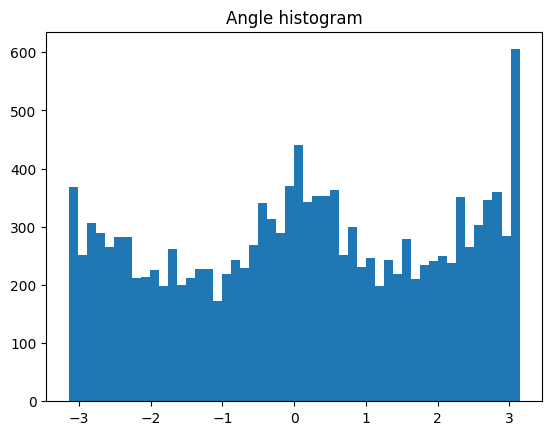

In [11]:
traindataset = CarDataset(train_id, train_df)
valdataset = CarDataset(test_id, train_df)

# Your angle histogram should be as flat as possible to reduce overfitting!
target = train_df["angle"]
plt.hist(target, bins=50)
plt.title("Angle histogram")
plt.show()


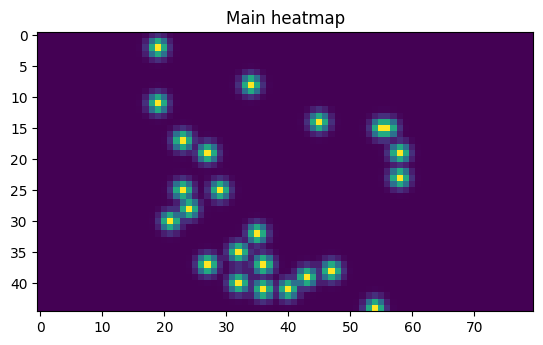

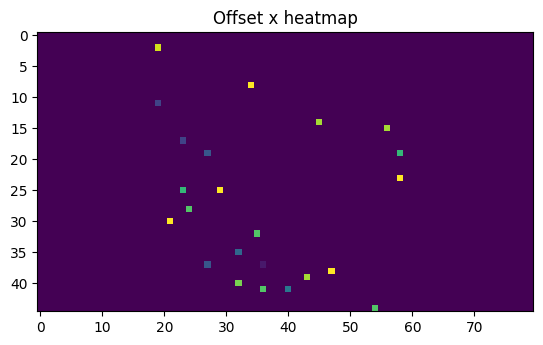

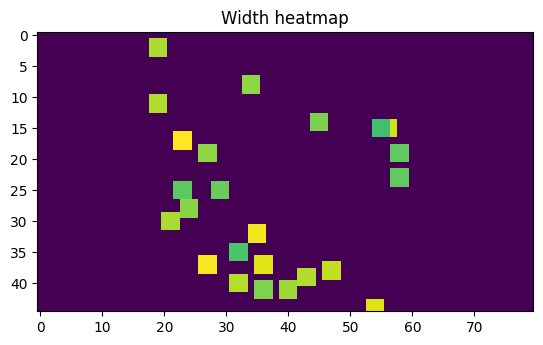

(2, 45, 80)


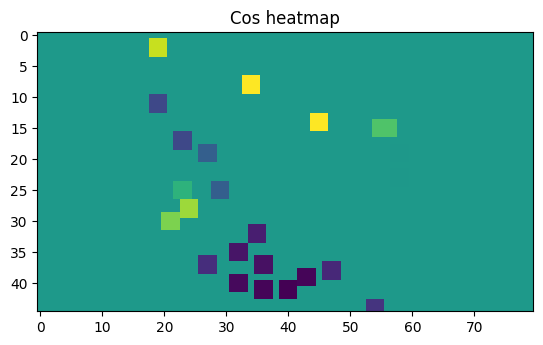

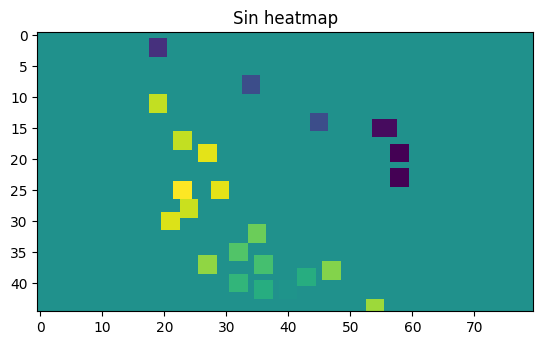

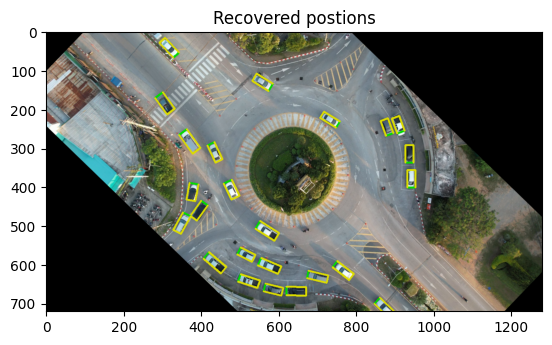

In [17]:
# Check traindataset

k = random.randint(0, len(train_id))
# Test dataset
img, hm, offset, regr, cos_sin_hm = traindataset[k]

plt.imshow(hm)
plt.title("Main heatmap")
plt.show()

plt.imshow(offset[0])
plt.title("Offset x heatmap")
plt.show()

plt.imshow(regr[0])
plt.title("Width heatmap")
plt.show()

print(cos_sin_hm.shape)

plt.imshow(cos_sin_hm[0])
plt.title("Cos heatmap")
plt.show()

plt.imshow(cos_sin_hm[1])
plt.title("Sin heatmap")
plt.show()

# Recover ball detection from heatmaps
img = cv2.imread(os.path.join(dataset_folder, train_id[k]))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = showbox(img, hm, offset, regr, cos_sin_hm, 0.99)

plt.imshow(img)
plt.title("Recovered postions")
plt.show()

In [18]:
train_loader = torch.utils.data.DataLoader(traindataset,batch_size=batch_size,shuffle=True)
val_loader = torch.utils.data.DataLoader(valdataset,batch_size=batch_size,shuffle=True)

## Define Centernet model

In [19]:
class centernet(nn.Module):
    def __init__(self):
        super(centernet, self).__init__()
        
        # Resnet-18 as backbone.
        basemodel = torchvision.models.resnet18(pretrained=True)
        
        # DO NOT FREEZE ResNet weights
        #for param in basemodel.parameters():
        #    param.requires_grad = False
        
        # Select only first layers up when you reach 80x45 dimensions with 256 channels
        self.base_model = nn.Sequential(*list(basemodel.children())[:-3])
        
        num_ch = 256
        head_conv = 64
        self.outc = nn.Sequential(
                nn.Conv2d(num_ch, head_conv, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(head_conv, 1, kernel_size=1, stride=1))
        
        self.outo = nn.Sequential(
                nn.Conv2d(num_ch, head_conv, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(head_conv, 2, kernel_size=1, stride=1))
        
        self.outr = nn.Sequential(
                nn.Conv2d(num_ch, head_conv, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(head_conv, 2, kernel_size=1, stride=1))
        
        self.outa = nn.Sequential(
                nn.Conv2d(num_ch, head_conv, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(head_conv, 2, kernel_size=1, stride=1))
        
    def forward(self, x):
        # [b, 3, 720, 1280]
        
        x = self.base_model(x)
        # [b, 128, 90, 160] 
        
        assert not torch.isnan(x).any()
        
        outc = self.outc(x) 
        # [b, 1, 90, 160]
        assert not torch.isnan(outc).any()
        
        outo = self.outo(x)
        # [b, 2, 90, 160]
        assert not torch.isnan(outo).any()
        
        outr = self.outr(x)
        outa = self.outa(x)
        
        return outc, outo, outr, outa

In [20]:
model = centernet()
# Check if it runs correctly
output = model(torch.rand(1,3,input_height,input_width))
print(output[0].size())
print(output[1].size())


/home/antoine/Documents/kaggle/pytorch/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/antoine/Documents/kaggle/pytorch/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([1, 1, 45, 80])
torch.Size([1, 2, 45, 80])


In [21]:
summary(model, (1, 3, input_height, input_width))

Layer (type:depth-idx)                        Output Shape              Param #
centernet                                     [1, 1, 45, 80]            --
├─Sequential: 1-1                             [1, 256, 45, 80]          --
│    └─Conv2d: 2-1                            [1, 64, 360, 640]         9,408
│    └─BatchNorm2d: 2-2                       [1, 64, 360, 640]         128
│    └─ReLU: 2-3                              [1, 64, 360, 640]         --
│    └─MaxPool2d: 2-4                         [1, 64, 180, 320]         --
│    └─Sequential: 2-5                        [1, 64, 180, 320]         --
│    │    └─BasicBlock: 3-1                   [1, 64, 180, 320]         73,984
│    │    └─BasicBlock: 3-2                   [1, 64, 180, 320]         73,984
│    └─Sequential: 2-6                        [1, 128, 90, 160]         --
│    │    └─BasicBlock: 3-3                   [1, 128, 90, 160]         230,144
│    │    └─BasicBlock: 3-4                   [1, 128, 90, 160]         295,42

# Define Loss (Focal loss + L1-loss)

In [22]:
def focal_loss(pred_mask, gt,gamma=0.2):
    """
    Focal loss was introduced to address the class imbalance problem
    For example here, most of the pixels in the heatmap are negative.
    
    We split the focal loss between positive and negative losses.
    
    https://arxiv.org/pdf/1708.02002.pdf
    
    Code taken from the CenterNet repo.
    """
    gt = gt.unsqueeze(1).float()

    pos_inds = gt.ge(1.0).float()
    neg_inds = gt.lt(1.0).float()
    
    neg_weights = torch.pow(1 - gt, 4)
    
    # add 1e-12 to avoid nan values
    pos_loss = - torch.pow(1 - pred_mask, gamma) * torch.log(pred_mask + 1e-12) * pos_inds # [2, 1, 128, 128]
    neg_loss = - torch.pow(pred_mask, gamma) * torch.log(1 - pred_mask + 1e-12) * neg_inds * neg_weights # [2, 1, 128, 128]
    
    loss = 0
    
    num_pos  = pos_inds.float().sum() # scalar number of positives
    pos_loss = pos_loss.sum()
    neg_loss = neg_loss.sum()
    
    if num_pos == 0:
        loss = neg_loss
    else:
        pos_loss /= num_pos
        neg_loss /= num_pos
        loss = pos_loss + neg_loss
        
    assert not torch.isnan(pos_loss)
    assert not torch.isnan(neg_loss)
        
    return loss, pos_loss, neg_loss


def _regr_loss(off_pred, off_gt, wh_pred, wh_gt, angle_pred, angle_gt, hm_gt):
    ''' L1 regression loss
    We compute l1 loss over mask of positive pixels for offset, width/height and sine/cosine angle
    '''
    mask = hm_gt.unsqueeze(1).float().ge(1.0).float()
    
    num = mask.float().sum() 
    mask = mask.expand_as(off_gt).float()
    
    assert off_pred.size() == mask.size()
    off_pred = off_pred * mask
    off_gt = off_gt * mask
    wh_pred = wh_pred * mask
    wh_gt = wh_gt * mask
    angle_pred = angle_pred * mask
    angle_gt = angle_gt * mask
    

    off_loss = nn.functional.l1_loss(off_pred, off_gt, reduction='sum') / (num + 1e-4)
    
    # Scale with 0.1 width and height loss (change it you need)
    wh_loss = 0.1 * nn.functional.l1_loss(wh_pred, wh_gt, reduction='sum') / (num + 1e-4)
    
    angle_loss = nn.functional.l1_loss(angle_pred, angle_gt, reduction='sum') / (num + 1e-4)
    
    return off_loss, wh_loss, angle_loss

def global_loss(hm_pred, hm_gt, off_pred, off_gt, wh_pred, wh_gt, angle_pred, angle_gt):
    """
    Global loss is the sum of the focal loss and of the offset loss
        
    Focal loss is the sum of pos_loss and neg_loss, we extract them just for the record
    """
    
    pred_mask = torch.sigmoid(hm_pred[:, 0])
  
    pred_mask = pred_mask.unsqueeze(1).float()
    
    foc_loss, pos_loss, neg_loss = focal_loss(pred_mask, hm_gt)
     
    off_loss, wh_loss, angle_loss = _regr_loss(off_pred, off_gt, wh_pred, wh_gt, angle_pred, angle_gt, hm_gt)
    
    assert not torch.isnan(off_loss)
        
    return foc_loss, pos_loss, neg_loss, off_loss, wh_loss, angle_loss

# Training

In [23]:
def train(epoch):
    print(f'epochs {epoch+1}/{epochs}')
    print(f'Learning rate : {optimizer.param_groups[0]["lr"]}')
    train_loss = 0.0
    train_pos_loss = 0.0
    train_neg_loss = 0.0
    train_off_loss = 0.0
    train_wh_loss = 0.0
    train_angle_loss = 0.0
    t = tqdm(train_loader)
    rd = np.random.rand()
    
    # Training
    model.train()
    
    for idx, (img, hm, offset, regr, angle) in enumerate(t):       
        # send to gpu
        img = img.to(device)
        hm_gt = hm.to(device)
        offset_gt = offset.to(device)
        wh_gt = regr.to(device)
        angle_gt = angle.to(device)
        # set opt
        optimizer.zero_grad()
        
        # run model
        preds_hm, preds_offset, preds_wh, preds_angle = model(img)
        assert not np.isnan(preds_hm.cpu().detach().numpy()[0, 0, 0, 0])
            
        foc_loss, pos_loss, neg_loss, off_loss, wh_loss, angle_loss = global_loss(preds_hm, hm_gt, preds_offset, offset_gt, preds_wh, wh_gt, preds_angle, angle_gt)
        loss = foc_loss + off_loss + wh_loss + angle_loss
        
        if torch.isnan(loss):
            print("NAN loss")
            continue
            
        # misc
        train_loss += float(loss) # TRICK to avoid GPU memory increasing
        train_pos_loss += float(pos_loss)
        train_neg_loss += float(neg_loss)
        train_off_loss += float(off_loss)
        train_wh_loss += float(wh_loss)
        train_angle_loss += float(angle_loss)
        
        loss.backward()
        # NB: I tried to use gradient clipping to avoid NaN values but it didnt work as expected
        optimizer.step()
        
        t.set_description(f'(l={train_loss/(idx+1):.2f}) (pos={train_pos_loss/(idx+1):.3f}) (neg={train_neg_loss/(idx+1):.3f}) (off={train_off_loss/(idx+1):.3f}) (wh={train_wh_loss/(idx+1):.3f}) (a={train_angle_loss/(idx+1):.3f})')
    
    # Validation
    val_loss = 0.0
    val_pos_loss = 0.0
    val_neg_loss = 0.0
    val_off_loss = 0.0
    val_wh_loss = 0.0
    val_angle_loss = 0.0
    
    model.eval()
    
    with torch.no_grad():
        for idx, (img, hm, offset, regr, angle) in enumerate(tqdm(val_loader)):       
            # send to gpu
            img = img.to(device)
            hm_gt = hm.to(device)
            offset_gt = offset.to(device)
            wh_gt = regr.to(device)
            angle_gt = angle.to(device)

            # run model
            preds_hm, preds_offset, preds_wh, preds_angle = model(img)

            foc_loss, pos_loss, neg_loss, off_loss, wh_loss, angle_loss = global_loss(preds_hm, hm_gt, preds_offset, offset_gt, preds_wh, wh_gt, preds_angle, angle_gt)
            
            loss = foc_loss + off_loss + wh_loss + angle_loss
            # misc
            val_loss += float(loss)
            val_pos_loss += float(pos_loss)
            val_neg_loss += float(neg_loss)
            val_off_loss += float(off_loss)
            val_wh_loss += float(wh_loss)
            val_angle_loss += float(angle_loss)


    print(f'train loss : {train_loss/len(train_loader):.4f}')
    print(f'Pos loss : {train_pos_loss/len(train_loader):.4f}')
    print(f'Neg loss : {train_neg_loss/len(train_loader):.4f}')
    print(f'Off loss : {train_off_loss/len(train_loader):.4f}')
    print(f'Wh loss : {train_wh_loss/len(train_loader):.4f}')
    print(f'Angle loss : {train_angle_loss/len(train_loader):.4f}')
    
    print("")
    print(f'Val loss : {val_loss/len(val_loader):.4f}')
    print(f'Val Pos loss : {val_pos_loss/len(val_loader):.4f}')
    print(f'Val Neg loss : {val_neg_loss/len(val_loader):.4f}')
    print(f'Val Off loss : {val_off_loss/len(val_loader):.4f}')
    print(f'Val Wh loss : {val_wh_loss/len(val_loader):.4f}')
    print(f'Val Angle loss : {val_angle_loss/len(val_loader):.4f}')
    
    # save logs
    log_epoch = {'epoch': epoch+1, 'lr': optimizer.state_dict()['param_groups'][0]['lr'],
                'train_loss': train_loss/len(train_loader), 'train_pos_loss': train_pos_loss/len(train_loader),
                'train_neg_loss': train_neg_loss/len(train_loader), 'train_off_loss': train_off_loss/len(train_loader), 
                'val_loss': val_loss/len(val_loader), 'val_pos_loss': val_pos_loss/len(val_loader),
                'val_neg_loss': val_neg_loss/len(val_loader), 'val_off_loss': val_off_loss/len(val_loader)}
    logs.append(log_epoch)
    
    return val_loss/len(val_loader)

In [24]:
model = centernet()
#model.load_state_dict(torch.load("centernet-oriented-bbox.pth"))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

logs = []
best_loss = float('inf')

In [25]:
epochs = 15

for epoch in range(epochs):
    val_loss = train(epoch)
    if val_loss < best_loss:
        best_loss = val_loss
        print(f"Improved validation loss to {best_loss:.3f}")
        torch.save(model.state_dict(), "centernet-oriented-bbox.pth")   


epochs 1/15
Learning rate : 0.0001


(l=9.82) (pos=0.941) (neg=7.625) (off=0.272) (wh=0.091) (a=0.896): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 460/460 [00:56<00:00,  8.15it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:13<00:00,  8.39it/s]


train loss : 9.8242
Pos loss : 0.9411
Neg loss : 7.6247
Off loss : 0.2720
Wh loss : 0.0909
Angle loss : 0.8956

Val loss : 1.3124
Val Pos loss : 0.3050
Val Neg loss : 0.3026
Val Off loss : 0.1824
Val Wh loss : 0.0560
Val Angle loss : 0.4664
Improved validation loss to 1.312
epochs 2/15
Learning rate : 0.0001


(l=0.90) (pos=0.131) (neg=0.215) (off=0.167) (wh=0.040) (a=0.350): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 460/460 [01:01<00:00,  7.49it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:13<00:00,  8.49it/s]


train loss : 0.9042
Pos loss : 0.1313
Neg loss : 0.2154
Off loss : 0.1673
Wh loss : 0.0402
Angle loss : 0.3500

Val loss : 0.7533
Val Pos loss : 0.0959
Val Neg loss : 0.1898
Val Off loss : 0.1536
Val Wh loss : 0.0353
Val Angle loss : 0.2787
Improved validation loss to 0.753
epochs 3/15
Learning rate : 0.0001


(l=0.63) (pos=0.073) (neg=0.127) (off=0.146) (wh=0.033) (a=0.249): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 460/460 [01:01<00:00,  7.46it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:13<00:00,  8.57it/s]


train loss : 0.6281
Pos loss : 0.0734
Neg loss : 0.1266
Off loss : 0.1462
Wh loss : 0.0330
Angle loss : 0.2488

Val loss : 0.6330
Val Pos loss : 0.0828
Val Neg loss : 0.1294
Val Off loss : 0.1637
Val Wh loss : 0.0295
Val Angle loss : 0.2276
Improved validation loss to 0.633
epochs 4/15
Learning rate : 0.0001


(l=0.50) (pos=0.050) (neg=0.092) (off=0.137) (wh=0.030) (a=0.188): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 460/460 [01:02<00:00,  7.33it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:13<00:00,  8.26it/s]


train loss : 0.4970
Pos loss : 0.0502
Neg loss : 0.0917
Off loss : 0.1369
Wh loss : 0.0302
Angle loss : 0.1880

Val loss : 0.6225
Val Pos loss : 0.1359
Val Neg loss : 0.0933
Val Off loss : 0.1552
Val Wh loss : 0.0303
Val Angle loss : 0.2079
Improved validation loss to 0.623
epochs 5/15
Learning rate : 0.0001


(l=0.40) (pos=0.035) (neg=0.068) (off=0.127) (wh=0.028) (a=0.144): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 460/460 [01:02<00:00,  7.35it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:13<00:00,  8.35it/s]


train loss : 0.4020
Pos loss : 0.0354
Neg loss : 0.0680
Off loss : 0.1266
Wh loss : 0.0277
Angle loss : 0.1444

Val loss : 0.5162
Val Pos loss : 0.0981
Val Neg loss : 0.1004
Val Off loss : 0.1376
Val Wh loss : 0.0262
Val Angle loss : 0.1538
Improved validation loss to 0.516
epochs 6/15
Learning rate : 0.0001


(l=0.36) (pos=0.030) (neg=0.058) (off=0.121) (wh=0.025) (a=0.125): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 460/460 [01:03<00:00,  7.25it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:13<00:00,  8.30it/s]


train loss : 0.3592
Pos loss : 0.0297
Neg loss : 0.0584
Off loss : 0.1213
Wh loss : 0.0252
Angle loss : 0.1247

Val loss : 0.5270
Val Pos loss : 0.1218
Val Neg loss : 0.0882
Val Off loss : 0.1379
Val Wh loss : 0.0271
Val Angle loss : 0.1520
epochs 7/15
Learning rate : 0.0001


(l=0.33) (pos=0.024) (neg=0.049) (off=0.114) (wh=0.025) (a=0.114): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 460/460 [01:00<00:00,  7.64it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:13<00:00,  8.40it/s]


train loss : 0.3258
Pos loss : 0.0236
Neg loss : 0.0487
Off loss : 0.1144
Wh loss : 0.0247
Angle loss : 0.1144

Val loss : 0.5388
Val Pos loss : 0.1465
Val Neg loss : 0.0737
Val Off loss : 0.1412
Val Wh loss : 0.0257
Val Angle loss : 0.1517
epochs 8/15
Learning rate : 0.0001


(l=0.30) (pos=0.022) (neg=0.044) (off=0.112) (wh=0.024) (a=0.103): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 460/460 [01:00<00:00,  7.64it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:13<00:00,  8.50it/s]


train loss : 0.3044
Pos loss : 0.0215
Neg loss : 0.0443
Off loss : 0.1116
Wh loss : 0.0241
Angle loss : 0.1029

Val loss : 0.4360
Val Pos loss : 0.0987
Val Neg loss : 0.0649
Val Off loss : 0.1273
Val Wh loss : 0.0231
Val Angle loss : 0.1220
Improved validation loss to 0.436
epochs 9/15
Learning rate : 0.0001


(l=0.28) (pos=0.017) (neg=0.039) (off=0.106) (wh=0.023) (a=0.096): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 460/460 [01:00<00:00,  7.59it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:13<00:00,  8.53it/s]


train loss : 0.2798
Pos loss : 0.0172
Neg loss : 0.0389
Off loss : 0.1056
Wh loss : 0.0227
Angle loss : 0.0955

Val loss : 0.4335
Val Pos loss : 0.0926
Val Neg loss : 0.0643
Val Off loss : 0.1294
Val Wh loss : 0.0253
Val Angle loss : 0.1219
Improved validation loss to 0.434
epochs 10/15
Learning rate : 0.0001


(l=0.26) (pos=0.015) (neg=0.033) (off=0.103) (wh=0.022) (a=0.091): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 460/460 [01:00<00:00,  7.64it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:13<00:00,  8.39it/s]


train loss : 0.2644
Pos loss : 0.0152
Neg loss : 0.0331
Off loss : 0.1030
Wh loss : 0.0221
Angle loss : 0.0910

Val loss : 0.4412
Val Pos loss : 0.0894
Val Neg loss : 0.0681
Val Off loss : 0.1322
Val Wh loss : 0.0244
Val Angle loss : 0.1271
epochs 11/15
Learning rate : 0.0001


(l=0.25) (pos=0.013) (neg=0.030) (off=0.100) (wh=0.021) (a=0.087): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 460/460 [01:00<00:00,  7.58it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:13<00:00,  8.61it/s]


train loss : 0.2513
Pos loss : 0.0130
Neg loss : 0.0298
Off loss : 0.1002
Wh loss : 0.0212
Angle loss : 0.0871

Val loss : 0.4506
Val Pos loss : 0.1339
Val Neg loss : 0.0478
Val Off loss : 0.1231
Val Wh loss : 0.0226
Val Angle loss : 0.1231
epochs 12/15
Learning rate : 0.0001


(l=0.24) (pos=0.011) (neg=0.027) (off=0.098) (wh=0.021) (a=0.083): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 460/460 [01:00<00:00,  7.54it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:13<00:00,  8.53it/s]


train loss : 0.2392
Pos loss : 0.0111
Neg loss : 0.0268
Off loss : 0.0978
Wh loss : 0.0205
Angle loss : 0.0831

Val loss : 0.4640
Val Pos loss : 0.1063
Val Neg loss : 0.0881
Val Off loss : 0.1318
Val Wh loss : 0.0225
Val Angle loss : 0.1153
epochs 13/15
Learning rate : 0.0001


(l=0.25) (pos=0.013) (neg=0.029) (off=0.098) (wh=0.021) (a=0.084): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 460/460 [01:00<00:00,  7.61it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:13<00:00,  8.53it/s]


train loss : 0.2453
Pos loss : 0.0133
Neg loss : 0.0290
Off loss : 0.0980
Wh loss : 0.0207
Angle loss : 0.0843

Val loss : 0.4625
Val Pos loss : 0.1387
Val Neg loss : 0.0569
Val Off loss : 0.1281
Val Wh loss : 0.0224
Val Angle loss : 0.1164
epochs 14/15
Learning rate : 0.0001


(l=0.22) (pos=0.008) (neg=0.021) (off=0.091) (wh=0.020) (a=0.077): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 460/460 [01:00<00:00,  7.59it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:13<00:00,  8.59it/s]


train loss : 0.2170
Pos loss : 0.0083
Neg loss : 0.0208
Off loss : 0.0908
Wh loss : 0.0196
Angle loss : 0.0775

Val loss : 0.4132
Val Pos loss : 0.1101
Val Neg loss : 0.0528
Val Off loss : 0.1218
Val Wh loss : 0.0218
Val Angle loss : 0.1066
Improved validation loss to 0.413
epochs 15/15
Learning rate : 0.0001


(l=0.21) (pos=0.008) (neg=0.019) (off=0.090) (wh=0.019) (a=0.073): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 460/460 [01:00<00:00,  7.60it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:13<00:00,  8.50it/s]

train loss : 0.2095
Pos loss : 0.0079
Neg loss : 0.0194
Off loss : 0.0900
Wh loss : 0.0193
Angle loss : 0.0729

Val loss : 0.4567
Val Pos loss : 0.1387
Val Neg loss : 0.0600
Val Off loss : 0.1280
Val Wh loss : 0.0214
Val Angle loss : 0.1087


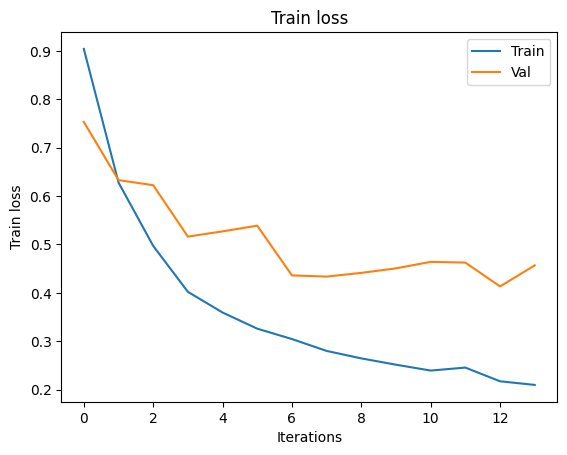

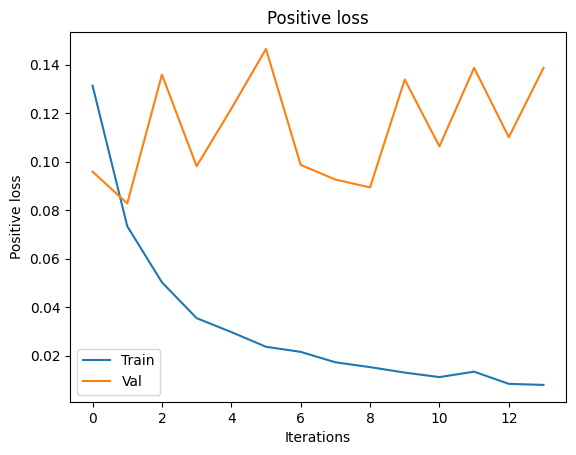

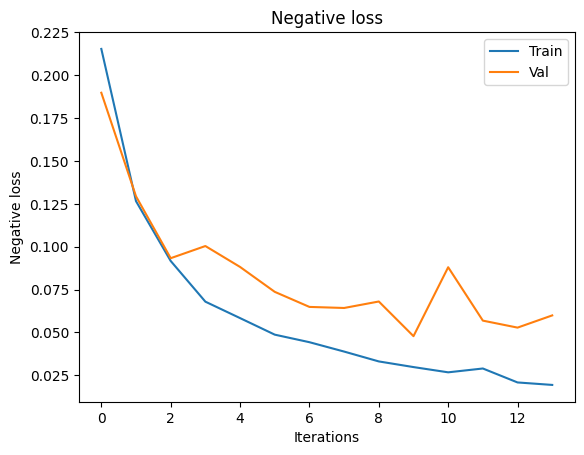

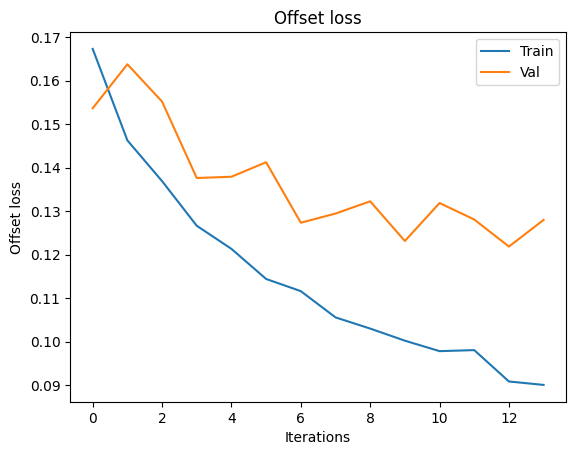

In [26]:
loss_iter = [log["train_loss"] for log in logs]
val_loss_iter = [log["val_loss"] for log in logs]
plt.plot(loss_iter[1:], label="Train")
plt.plot(val_loss_iter[1:], label="Val")
plt.xlabel("Iterations")
plt.ylabel("Train loss")
plt.title("Train loss")
plt.legend()
plt.show()

pos_loss_iter = [log["train_pos_loss"] for log in logs]
val_pos_loss_iter = [log["val_pos_loss"] for log in logs]
plt.plot(pos_loss_iter[1:], label="Train")
plt.plot(val_pos_loss_iter[1:], label="Val")
plt.xlabel("Iterations")
plt.ylabel("Positive loss")
plt.title("Positive loss")
plt.legend()
plt.show()

neg_loss_iter = [log["train_neg_loss"] for log in logs]
val_neg_loss_iter = [log["val_neg_loss"] for log in logs]
plt.plot(neg_loss_iter[1:], label="Train")
plt.plot(val_neg_loss_iter[1:], label="Val")
plt.xlabel("Iterations")
plt.ylabel("Negative loss")
plt.title("Negative loss")
plt.legend()
plt.show()

off_loss_iter = [log["train_off_loss"] for log in logs]
val_off_loss_iter = [log["val_off_loss"] for log in logs]
plt.plot(off_loss_iter[1:], label="Train")
plt.plot(val_off_loss_iter[1:], label="Val")
plt.xlabel("Iterations")
plt.ylabel("Offset loss")
plt.title("Offset loss")
plt.legend()
plt.show()

# Show predictions

(2, 45, 80)


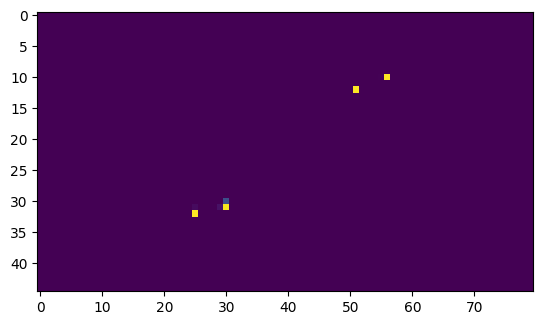

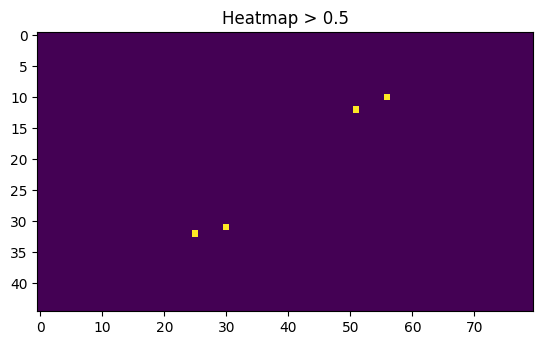

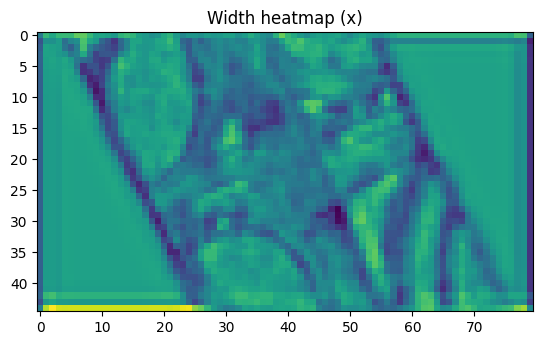

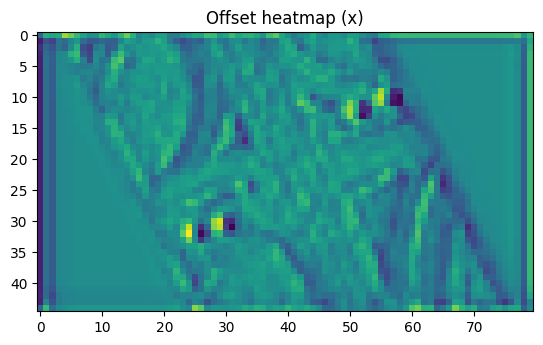

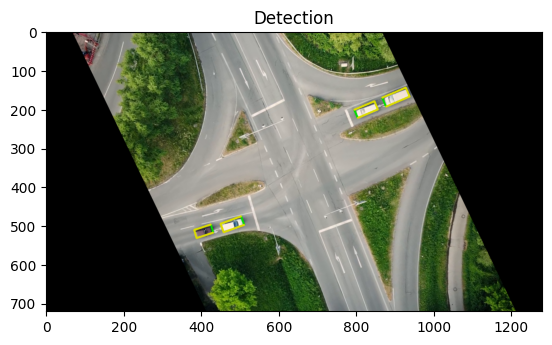

(2, 45, 80)


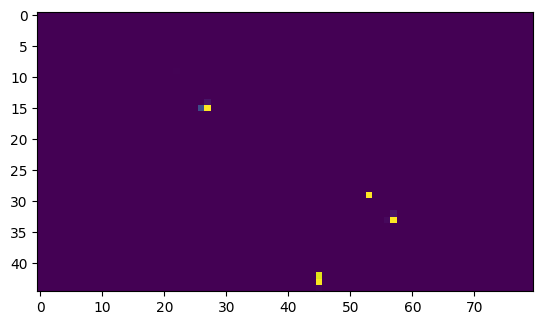

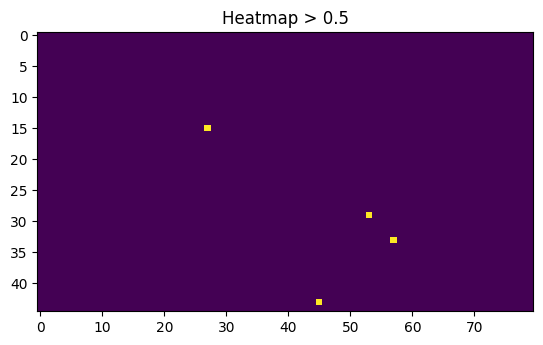

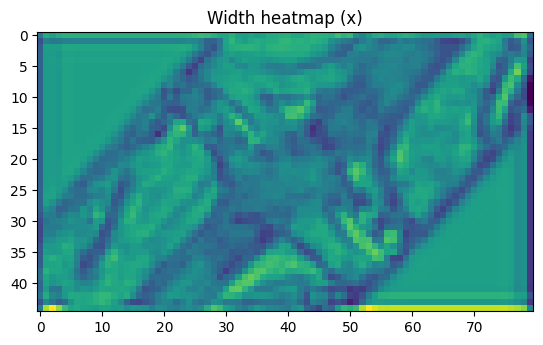

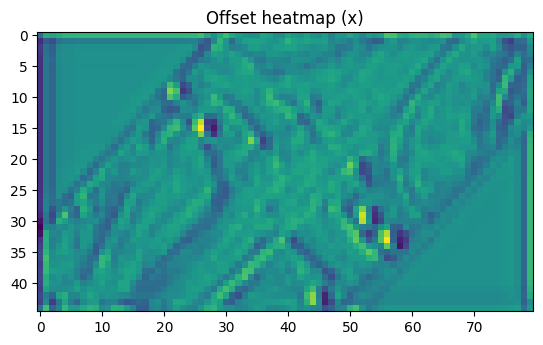

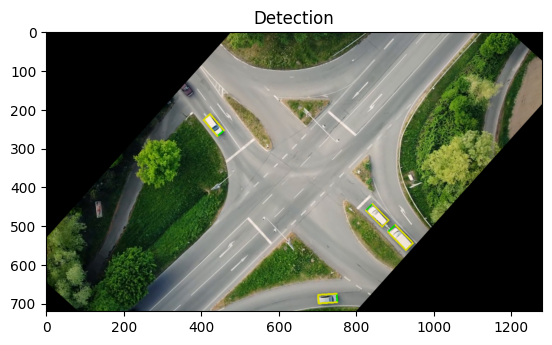

(2, 45, 80)


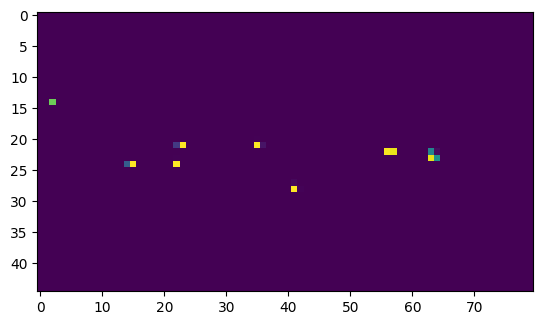

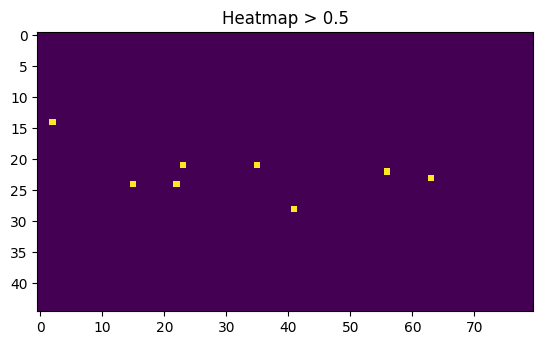

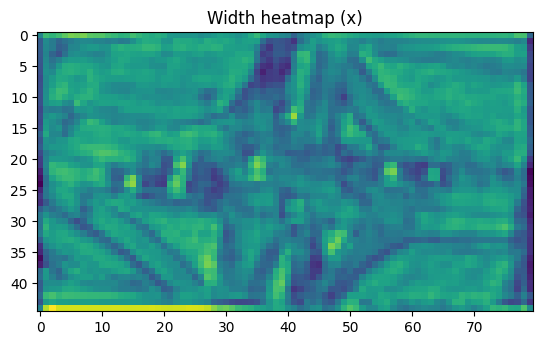

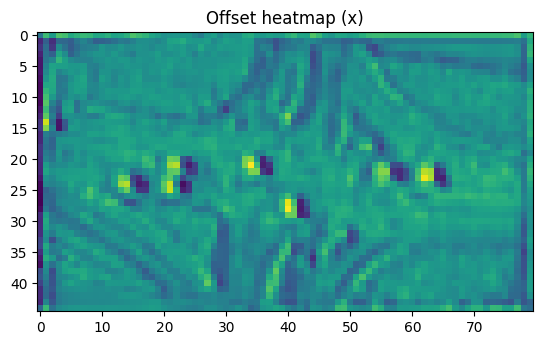

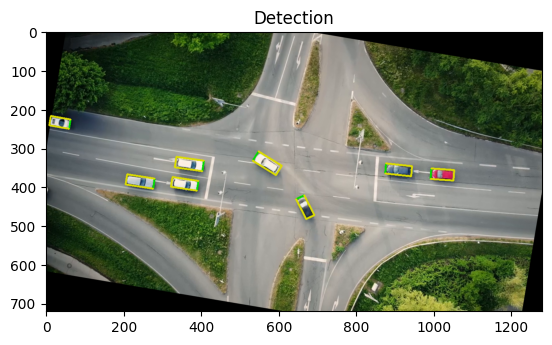

In [28]:
model.load_state_dict(torch.load("centernet-oriented-bbox.pth"))
model.eval()

threshold = 0.5

for id in range(3):
    img, hm_gt, offset_gt, regr_gt, angle_gt = valdataset[id]
    img = torch.from_numpy(img)
    with torch.no_grad():
        hm, offset, wh, angle = model(img.to(device).float().unsqueeze(0))

    
    hm = hm.cpu().numpy().squeeze(0).squeeze(0)
    offset = offset.cpu().numpy().squeeze(0)
    wh = wh.cpu().numpy().squeeze(0)
    angle = angle.cpu().numpy().squeeze(0)
    
    print(angle.shape)

    # show image
    img_id = test_id[id]
    img = cv2.imread(os.path.join(dataset_folder, img_id))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #img = cv2.resize(img, (input_size, input_size))

    # get boxes
    hm = torch.sigmoid(torch.from_numpy(hm)).numpy()
    plt.imshow(hm)
    plt.show()
    hm = select(hm, threshold)
    
    plt.imshow(hm>threshold)
    plt.title(f"Heatmap > {threshold}")
    plt.show()
    
    plt.imshow(wh[0])
    plt.title("Width heatmap (x)")
    plt.show()
    
    sample = showbox(img, hm, offset, wh, angle, threshold)
    plt.imshow(offset[0])
    plt.title("Offset heatmap (x)")
    plt.show()
    
    
    # show gt
    #fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    plt.imshow(sample)
    plt.title("Detection")
    plt.show()